**This notebook is my own implementation and might have been modified from the original**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save teh figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn $\geq$ 0.20

In [1]:
# Python >= 3.5 is requred
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout = True, fig_extension = "png", resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

# MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)

In [ ]:
mnist.keys()

In [3]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

Saving figure some_digit_plot


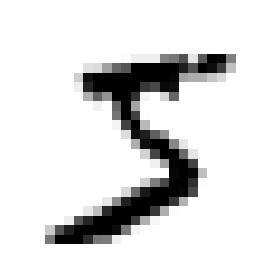

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [9]:
y[0]

'5'

In [10]:
y = y.astype(np.uint8)

In [4]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
              interpolation = "nearest")
    plt.axis("off")

In [5]:
# Extra
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis = 1))
    image = np.concatenate(row_images, axis = 0)
    plt.imshow(image, cmap = mpl.cm.binary, ** options)
    plt.axis("off")

Saving figure more_digits_plot


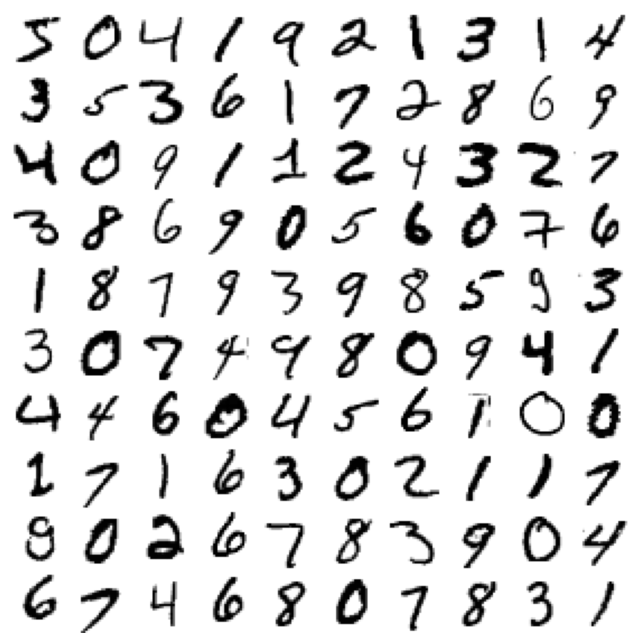

In [8]:
plt.figure(figsize = (9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)
save_fig("more_digits_plot")
plt.show()

In [14]:
y[1]

0

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note:** some hyperparameters will have a different default value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state =42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

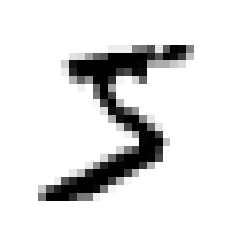

In [18]:
plot_digit(some_digit)

In [19]:
sgd_clf.predict([some_digit])

array([ True])

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy", n_jobs = -1)

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [22]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, n_jobs = -1)

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [26]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [28]:
pp = 3530 / (3530 + 687)

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [30]:
rr = 3530 / (3530 + 1891)

In [31]:
ff1 = 2 / (1/pp + 1/rr)
ff1

0.7325171197343847

In [32]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [35]:
y_some_digit_pred

array([ True])

In [36]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


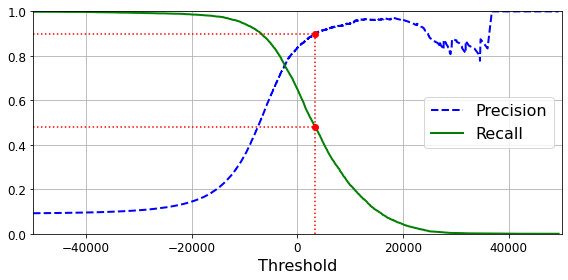

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2)
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth = 2)
    plt.legend(loc = "center right", fontsize = 16) 
    plt.xlabel("Threshold", fontsize = 16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [40]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


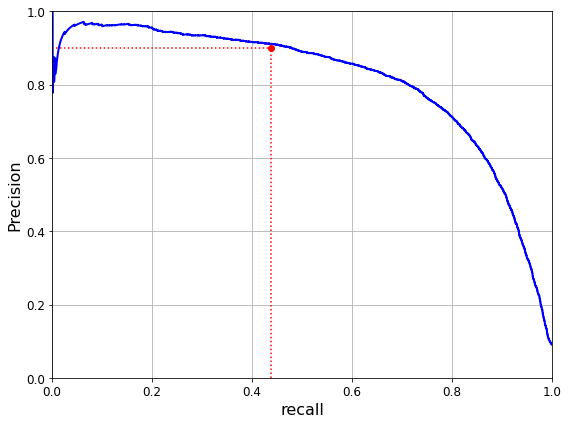

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()


In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [43]:
threshold_90_precision

3370.0194991439557

In [44]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [45]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [46]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


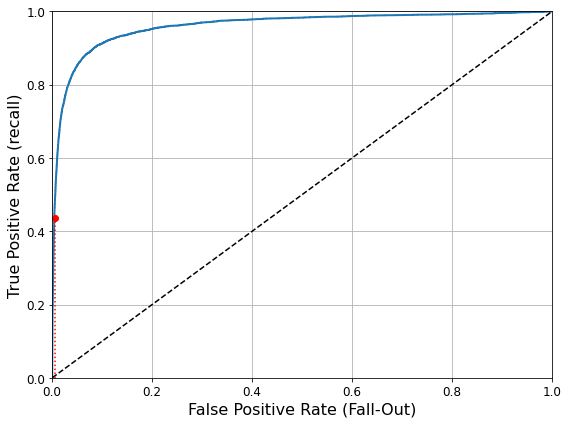

In [48]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') #dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize = 16)
    plt.ylabel('True Positive Rate (recall)', fontsize = 16)
    plt.grid(True)
    
plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
save_fig("roc_curve_plot")
plt.show()

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Note:** we set `n_esitomators = 100` to be future-proof since this will be the default value in Scikit-Learn 0.22

In [50]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba", n_jobs = -1)

In [51]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


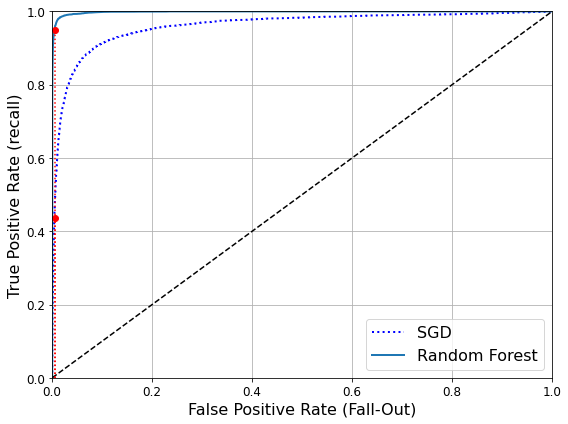

In [52]:
plt.figure(figsize = (8 ,6))
plt.plot(fpr, tpr, "b:", linewidth = 2, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0, 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc = "lower right", fontsize = 16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [53]:
roc_auc_score(y_train_5, y_scores_forest)

0.9986476957143594

In [54]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, n_jobs = -1)

In [55]:
precision_score(y_train_5, y_train_pred_forest)

0.990146750524109

In [56]:
recall_score(y_train_5, y_train_pred_forest)

0.8712414683637705

# Multiclass classification

In [57]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto", random_state = 42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [58]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

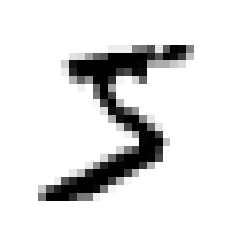

In [59]:
plot_digit(some_digit)

In [60]:
np.argmax(some_digit_scores)

5

In [61]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [62]:
svm_clf.classes_[5]

5

In [63]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma = "auto", random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [64]:
len(ovr_clf.estimators_)

10

In [65]:
ovr_clf.estimators_

[SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42)]

In [66]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [67]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [68]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy", n_jobs = -1)

array([0.87365, 0.85835, 0.8689 ])

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy", n_jobs = -1)

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3, n_jobs = -1)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

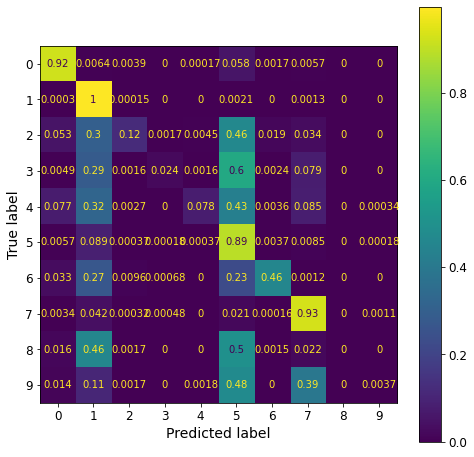

In [71]:
from sklearn.metrics import plot_confusion_matrix

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
plot_confusion_matrix(sgd_clf, X_train_scaled, y_train, ax = ax, normalize = 'true')

In [72]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


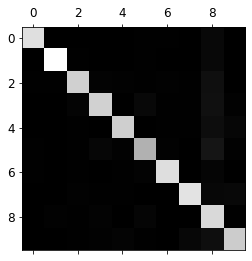

In [73]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout = False)

In [74]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


<ipython-input-2-22eadcc3d2a8>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


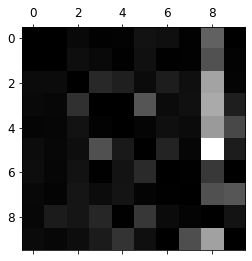

In [75]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
save_fig("confusion_matrix_errors_plot")

Saving figure error_analysis_digits_plot


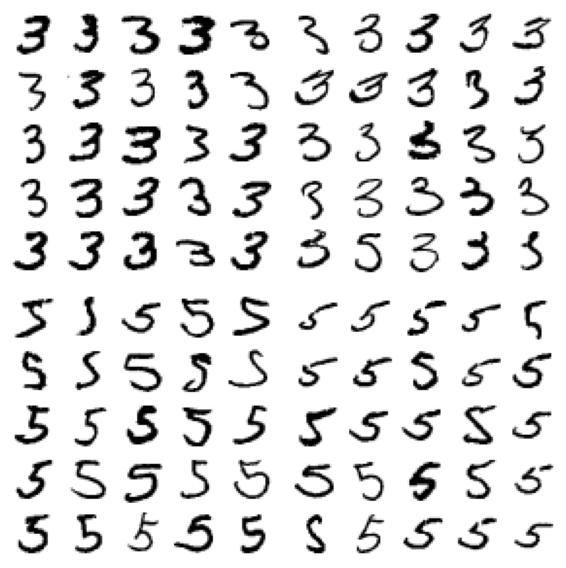

In [76]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel classification

In [77]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [79]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning:** the following cell may take a very long time (possibly hours depending on your hardware).

In [96]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs = -1)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

# Multioutput classification

In [80]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


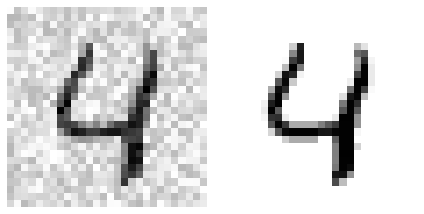

In [81]:
some_index = 4
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")

In [82]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

Saving figure cleaned_digit_example_plot


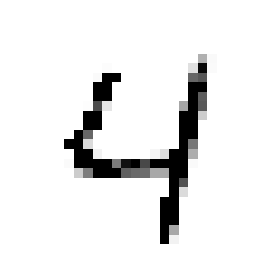

In [83]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Extra material

## Dummy (i.e. random) classifier

In [84]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
y_scores_dmy = y_probas_dmy[:,1]

/home/asalaheddin/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


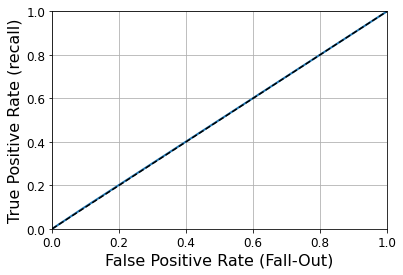

In [85]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4, n_jobs = -1)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [11]:
y_knn_pred = knn_clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

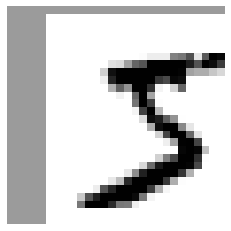

In [13]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new = 0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval = new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new = 100))

In [14]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis = 1, arr = X_train, dx = dx, dy = dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [15]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [16]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [17]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [18]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

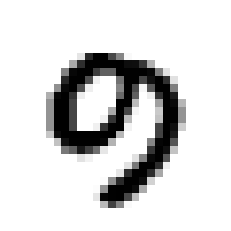

In [19]:
plot_digit(ambiguous_digit)

# Exercise solutions

# 1. An MNIST Classifier With Over 97% Accuracy 

**Warning**: the next cell may take hours to run, depending on your hardware.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}
    ]

knn_clf = KNeighborsClassifier(n_jobs = -1)

grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, verbose = 3)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=  39.8s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.9s remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=  40.1s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=  39.3s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=  39.9s
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=  39.9s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=  39.8s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=  39.5s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=  39.4s
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=  39.6s
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 19.8min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [15]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [17]:
grid_search.best_score_

0.9716166666666666

In [18]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

# 2. Data Augmentation 

In [7]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new = 0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval = new).reshape(784)

X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis = 1, arr = X_train, dx = dx, dy = dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [10]:
shuffle_idx = np.random.permutation(len(X_train_expanded))
X_train_expanded = X_train_expanded[shuffle_idx]
y_train_expanded = y_train_expanded[shuffle_idx]

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', n_jobs = -1)
knn_clf.fit(X_train_expanded, y_train_expanded)


KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

By simply augmenting the data, we got a 0.5% accuracy boost!

## 3. Tackle the Titanic dataset